In [171]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [172]:
def stock_data(stock_name, duration, company_name):#duration in years
   
    end_time = datetime.now()
    start_time = datetime(datetime.now().year - duration, datetime.now().month, datetime.now().day)  #using data of exactly duration year before
    stock=yf.download(stock_name,start_time,end_time)
    # stock["comany_name"]=company_name
    return stock
def plot(df, company):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Adj Close'], color='blue', label='Adjusted Close')
    plt.title(f'Adjusted Close Prices for {company} Inc.')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()  
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed


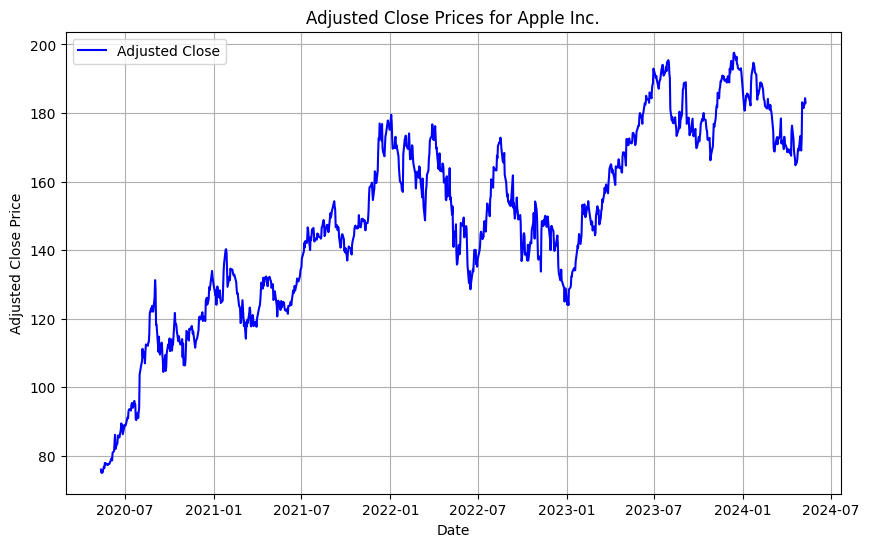

In [173]:
apple_stocks=stock_data('AAPL',4,'Apple')
plot(apple_stocks,'Apple')  

In [174]:
from sklearn.preprocessing import MinMaxScaler
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = pd.DataFrame()
for col in cols:
    scaled_col = scaler.fit_transform(apple_stocks[col].values.reshape(-1, 1))
    scaled_data[col] = scaled_col.flatten()
print(scaled_data)


          Open      High       Low     Close  Adj Close    Volume
0     0.035548  0.024033  0.021936  0.007756   0.007496  0.394683
1     0.023997  0.016409  0.006150  0.000000   0.000000  0.504082
2     0.008460  0.003853  0.002706  0.003899   0.003768  0.385057
3     0.000000  0.000000  0.000000  0.000124   0.000120  0.406237
4     0.026071  0.017530  0.020726  0.015079   0.014572  0.317253
...        ...       ...       ...       ...        ...       ...
1002  0.872532  0.874271  0.864040  0.864684   0.868336  0.155647
1003  0.881480  0.879979  0.871420  0.870377   0.873962  0.152039
1004  0.876599  0.865058  0.872486  0.873182   0.876734  0.059976
1005  0.874240  0.878022  0.877898  0.888282   0.891656  0.071183
1006  0.893275  0.881528  0.878062  0.875740   0.881286  0.076163

[1007 rows x 6 columns]


In [175]:
def split_data(data,percent_split):
    size=(int((np.shape(data)[0])*(percent_split/100)))
    return data[0:size], data[size:]

	
train_data,test_data=split_data(scaled_data, 70)

# def create_dataset(data, step):
# 	X, Y = list(), list()

	# for i in range(len(data)-step-1):
	# 	X.append(data[i:(i+step), 0])
	# 	Y.append(data[i + step, 0])
	# return np.array(X), np.array(Y)

In [176]:
def create_dataset(data , step):
    x,y=[],[]
    print(data.shape)
    print("dsf")
    print(data['Close'].index[0])
    for i in range((data.shape[0])-step-1):
    # for i in range(1):

        # print(i,(data[i+step]['Close']))
    
        x.append((data[i:i+step].values.tolist()))
        y.append(data['Close'][data['Close'].index[0]+i+step])
        # y.append(data[i+step]['Close'])


    return np.array(x),np.array(y)



# def create_dataset(data, step):
# 	X, Y = list(), list()
#     print(X,Y)
#     return X,Y
#     # print(data.shape)

# 	# for i in range(len(data)-step-1):
# 	# 	X.append(data[i:(i+step), 0])
# 	# 	Y.append(data[i + step, 0])
# 	# return np.array(X), np.array(Y)
step = 100
x_train, y_train = create_dataset(train_data, step)
x_test, y_test = create_dataset(test_data, step)


(704, 6)
dsf
0
(303, 6)
dsf
704


In [177]:
x_train.shape

(603, 100, 6)

In [178]:
# step = 100
# x_train, y_train = create_dataset(train_data, step)
# x_test, ytest = create_dataset(test_data, step)

# #1 is representing the number of features we are using , here we are doing univariate LSTM . Therefore , 1
# x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
# x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [179]:
def make_model(step ,numOfStacks, num_neurons):
    model=Sequential()
    model.add(LSTM(num_neurons[0],return_sequences=True,input_shape=(step,6)))
    for i in range(1,numOfStacks-1):
        model.add(LSTM(num_neurons[i],return_sequences=True))
    model.add(LSTM(num_neurons[-1]))
    
    model.add(Dense(1))
    return model

In [180]:
numOfStacks=3
num_neurons=[128,128,50]
model=make_model(step , numOfStacks,num_neurons)
model.compile(loss='mean_squared_error',optimizer='adam')

In [181]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 128)          69120     
                                                                 
 lstm_16 (LSTM)              (None, 100, 128)          131584    
                                                                 
 lstm_17 (LSTM)              (None, 50)                35800     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 236555 (924.04 KB)
Trainable params: 236555 (924.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [182]:
model.fit(x_train,y_train,validation_data=(x_test,ytest),epochs=100,batch_size=64,verbose=2)

Epoch 1/100
10/10 - 12s - loss: 0.0509 - val_loss: 0.0274 - 12s/epoch - 1s/step
Epoch 2/100
10/10 - 3s - loss: 0.0071 - val_loss: 0.0301 - 3s/epoch - 285ms/step
Epoch 3/100
10/10 - 3s - loss: 0.0054 - val_loss: 0.0055 - 3s/epoch - 302ms/step
Epoch 4/100
10/10 - 3s - loss: 0.0040 - val_loss: 0.0056 - 3s/epoch - 309ms/step
Epoch 5/100
10/10 - 3s - loss: 0.0034 - val_loss: 0.0057 - 3s/epoch - 295ms/step
Epoch 6/100
10/10 - 3s - loss: 0.0031 - val_loss: 0.0057 - 3s/epoch - 295ms/step
Epoch 7/100
10/10 - 3s - loss: 0.0031 - val_loss: 0.0044 - 3s/epoch - 302ms/step
Epoch 8/100
10/10 - 3s - loss: 0.0028 - val_loss: 0.0026 - 3s/epoch - 307ms/step
Epoch 9/100
10/10 - 3s - loss: 0.0028 - val_loss: 0.0024 - 3s/epoch - 316ms/step
Epoch 10/100
10/10 - 3s - loss: 0.0027 - val_loss: 0.0033 - 3s/epoch - 309ms/step
Epoch 11/100
10/10 - 4s - loss: 0.0026 - val_loss: 0.0041 - 4s/epoch - 389ms/step
Epoch 12/100
10/10 - 3s - loss: 0.0027 - val_loss: 0.0032 - 3s/epoch - 339ms/step
Epoch 13/100
10/10 - 3s - 

In [183]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)    

train_predict=fit.inverse_transform(train_predict)
test_predict=fit.inverse_transform(test_predict)

11/19 [================>.............] - ETA: 0s

7/7 [==============================] - 1s 72ms/step


In [184]:
train_predict

array([[115.0875  ],
       [113.92373 ],
       [114.74007 ],
       [113.96174 ],
       [114.54397 ],
       [115.03663 ],
       [115.88463 ],
       [119.53058 ],
       [120.953636],
       [121.696976],
       [121.125336],
       [119.95338 ],
       [117.737404],
       [117.0264  ],
       [116.95958 ],
       [116.40089 ],
       [115.92191 ],
       [115.53136 ],
       [116.30866 ],
       [114.5416  ],
       [115.02386 ],
       [112.62393 ],
       [111.30428 ],
       [111.16234 ],
       [112.89242 ],
       [116.04426 ],
       [117.657394],
       [117.647255],
       [116.793625],
       [117.882545],
       [118.79959 ],
       [119.176834],
       [119.77942 ],
       [120.02305 ],
       [119.5495  ],
       [119.373116],
       [119.04291 ],
       [117.265816],
       [116.66269 ],
       [117.22108 ],
       [117.9402  ],
       [118.89682 ],
       [121.52239 ],
       [123.157906],
       [123.76024 ],
       [123.31384 ],
       [123.65862 ],
       [124.2

In [185]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

145.52409308026517

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


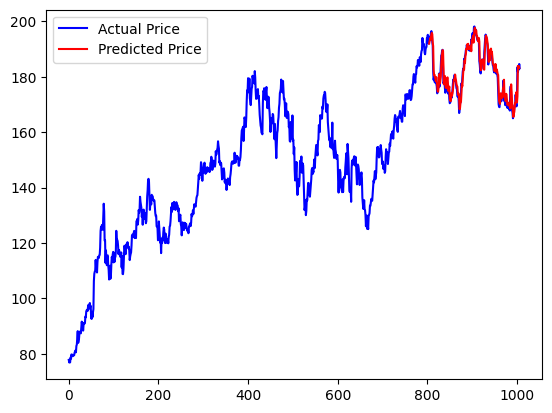

: 

In [186]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
print(testPredictPlot)
testPredictPlot[len(train_predict)+(step*2)+1:len(data)-1] = test_predict
# Plot the actual data in blue and the predicted data in red
plt.plot(unscaled_data, color='blue', label='Actual Price')
plt.plot(testPredictPlot, color='red', label='Predicted Price')
plt.legend()
plt.show()